# Task Solving with Code Generation, Execution and Debugging

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

````{=mdx}
:::info Requirements
Install the following packages before running the code below:
```bash
pip install pyautogen matplotlib yfinance
```

For more information, please refer to the [installation guide](/docs/installation/).
:::
````

In [ ]:
pip install pyautogen matplotlib yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
from IPython.display import Image, display

import autogen
from autogen.coding import LocalCommandLineCodeExecutor
import os
from google.colab import userdata
import openai

# config_list = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={"tags": ["gpt-4"]},  # comment out to get all
# )
# When using a single openai endpoint, you can use the following:
# config_list = [{"model": "gpt-4", "api_key": os.getenv("OPENAI_API_KEY")}]

In [ ]:
config_list=[
    {
        'model': userdata.get('AZURE_OPENAI_DEPLOYMENT'),
        'api_key': userdata.get('AZURE_OPENAI_API_KEY'),
        'base_url': userdata.get('AZURE_OPENAI_ENDPOINT'),
        'api_version': '2023-03-15-preview',
        'api_type': 'azure',

    }
]

# Set the OpenAI API key environment variable for the OpenAI client
os.environ['OPENAI_API_KEY'] = config_list[0]['api_key']
os.environ['OPENAI_API_BASE'] = config_list[0]['base_url']

# Check if the environment variables are set correctly
if not os.getenv('OPENAI_API_KEY') or not os.getenv('OPENAI_API_BASE'):
    raise ValueError("API key or base URL is not set correctly.")

# Set the API key for OpenAI client
openai.api_key = os.getenv('OPENAI_API_KEY')


## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [ ]:





# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "cache_seed": 41,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        # the executor to run the generated code
        "executor": LocalCommandLineCodeExecutor(work_dir="coding"),
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
chat_res = user_proxy.initiate_chat(
    assistant,
    # message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
     message="""Give me a list top 10 research papers on Fake Pharmaceutical product detection using Blockchain.""",

    summary_method="reflection_with_llm",
)

user_proxy (to assistant):

Give me a list top 10 research papers on Fake Pharmaceutical product detection using Blockchain.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To provide you with a list of the top 10 research papers on Fake Pharmaceutical product detection using Blockchain, I will need to search academic databases and repositories. I will use Python to scrape relevant information from Google Scholar.

Here is the Python code to perform the search and print the results:

```python
# filename: search_scholar.py
import requests
from bs4 import BeautifulSoup

def search_scholar(query, num_results=10):
    search_url = f"https://scholar.google.com/scholar?q={query.replace(' ', '+')}&num={num_results}"
    response = requests.get(search_url)
    if response.status_code != 200:
        print("Failed to retrieve data")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    results = []
    for it

#RAG

In [ ]:
# 1. create an RetrieveAssistantAgent instance named "assistant"
assistant = RetrieveAssistantAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    llm_config={
        "timeout": 600,
        "cache_seed": 42,
        "config_list": config_list,
    },
)

# 2. create the RetrieveUserProxyAgent instance named "ragproxyagent"
# By default, the human_input_mode is "ALWAYS", which means the agent will ask for human input at every step. We set it to "NEVER" here.
# `docs_path` is the path to the docs directory. It can also be the path to a single file, or the url to a single file. By default,
# it is set to None, which works only if the collection is already created.
# `task` indicates the kind of task we're working on. In this example, it's a `code` task.
# `chunk_token_size` is the chunk token size for the retrieve chat. By default, it is set to `max_tokens * 0.6`, here we set it to 2000.
# `custom_text_types` is a list of file types to be processed. Default is `autogen.retrieve_utils.TEXT_FORMATS`.
# This only applies to files under the directories in `docs_path`. Explicitly included files and urls will be chunked regardless of their types.
# In this example, we set it to ["non-existent-type"] to only process markdown files. Since no "non-existent-type" files are included in the `websit/docs`,
# no files there will be processed. However, the explicitly included urls will still be processed.
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=3,
    retrieve_config={
        "task": "code",
        "docs_path": [
            "https://microsoft.github.io/autogen/",
            os.path.join(os.path.abspath(""), "..", "website", "docs"),
        ],
        "custom_text_types": ["non-existent-type"],
        "chunk_token_size": 2000,
        "model": config_list[0]["model"],
        # "client": chromadb.PersistentClient(path="/tmp/chromadb"),  # deprecated, use "vector_db" instead
        "vector_db": "chroma",  # to use the deprecated `client` parameter, set to None and uncomment the line above
        "overwrite": False,  # set to True if you want to overwrite an existing collection
    },
    code_execution_config=False,  # set to False if you don't want to execute the code
)

NameError: name 'RetrieveAssistantAgent' is not defined

In [ ]:
# reset the assistant. Always reset the assistant before starting a new conversation.
assistant.reset()

# given a problem, we use the ragproxyagent to generate a prompt to be sent to the assistant as the initial message.
# the assistant receives the message and generates a response. The response will be sent back to the ragproxyagent for processing.
# The conversation continues until the termination condition is met, in RetrieveChat, the termination condition when no human-in-loop is no code block detected.
# With human-in-loop, the conversation will continue until the user says "exit".
code_problem = "Please enter the type of agent you want to create: give me code of Autogen agents with usecase of doing
      market research on current trends using some website search tool and some calculator tool, such that the agents
      can search the web and figure out how to diversify 100000$ worth of capital in gold, silver or stocks, give code
       for Autogen agents, figure out what agents will be needed and give complete code. Further execute the agents code
        to give me the output"
chat_result = ragproxyagent.initiate_chat(
    assistant, message=ragproxyagent.message_generator, problem=code_problem, search_string="spark"
)  # search_string is used as an extra filter for the embeddings search, in this case, we only want to search documents that contain "spark".

Trying to create collection.


2024-07-16 06:15:30,095 - autogen.agentchat.contrib.retrieve_user_proxy_agent - INFO - Found 1 chunks.
2024-07-16 06:15:30,103 - autogen.agentchat.contrib.vectordb.chromadb - INFO - No content embedding is provided. Will use the VectorDB's embedding function to generate the content embedding.


VectorDB returns doc_ids:  [[]]
No more context, will terminate.
ragproxyagent (to assistant):

TERMINATE

--------------------------------------------------------------------------------


#**NORMAL CODE WITH MARKET PROMPT**

In [ ]:





# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "cache_seed": 41,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        # the executor to run the generated code
        "executor": LocalCommandLineCodeExecutor(work_dir="coding"),
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
chat_res = user_proxy.initiate_chat(
    assistant,
    # message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
     message="""Please enter the type of agent you want to create: give me code of Autogen agents with usecase of doing
      market research on current trends using some website search tool and some calculator tool, such that the agents
      can search the web and figure out how to diversify 100000$ worth of capital in gold, silver or stocks, give code
       for Autogen agents, figure out what agents will be needed and give complete code. Further execute the agents code
        to give me the output""",

    summary_method="reflection_with_llm",
)

user_proxy (to assistant):

Please enter the type of agent you want to create: give me code of Autogen agents with usecase of doing
      market research on current trends using some website search tool and some calculator tool, such that the agents 
      can search the web and figure out how to diversify 100000$ worth of capital in gold, silver or stocks, give code
       for Autogen agents, figure out what agents will be needed and give complete code. Further execute the agents code
        to give me the output

--------------------------------------------------------------------------------
assistant (to user_proxy):

To create AutoGen agents for market research on current trends and to figure out how to diversify $100,000 worth of capital in gold, silver, or stocks, we need to follow these steps:

1. **Define the Agents**:
   - **WebSearchAgent**: This agent will search the web for current trends in gold, silver, and stocks.
   - **CalculatorAgent**: This agent will calculate the

# filename: autogen_agents.py

In [ ]:
# filename: autogen_agents.py

import requests
import json

class WebSearchAgent:
    def __init__(self, api_key):
        self.api_key = api_key
        self.trends = {}

    def search_trends(self):
        # Alpha Vantage API URLs
        urls = {
            "gold": f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GOLD&apikey={self.api_key}",
            "silver": f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SLV&apikey={self.api_key}",
            "stocks": f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&apikey={self.api_key}"
        }

        for asset, url in urls.items():
            response = requests.get(url)
            data = response.json()
            # Extract the latest closing price (this is a placeholder, actual extraction logic will depend on the API response structure)
            try:
                latest_date = list(data['Time Series (Daily)'].keys())[0]
                latest_close = float(data['Time Series (Daily)'][latest_date]['4. close'])
                self.trends[asset] = latest_close
            except KeyError:
                print(f"Trend data for {asset} not found.")
                self.trends[asset] = 0  # Default to 0 if not found

        return self.trends

class CalculatorAgent:
    def __init__(self, trends, capital):
        self.trends = trends
        self.capital = capital

    def calculate_diversification(self):
        total_trend = sum(self.trends.values())
        if total_trend == 0:
            print("No valid trend data found. Cannot calculate diversification.")
            return {}
        diversification = {asset: (trend / total_trend) * self.capital for asset, trend in self.trends.items()}
        return diversification

def main():
    # Step 1: Search for current trends
    api_key = "YOUR_ALPHA_VANTAGE_API_KEY"  # Replace with your actual API key
    web_search_agent = WebSearchAgent(api_key)
    trends = web_search_agent.search_trends()
    print("Current Trends:", trends)

    # Step 2: Calculate diversification
    capital = 100000  # $100,000
    calculator_agent = CalculatorAgent(trends, capital)
    diversification = calculator_agent.calculate_diversification()
    print("Diversification:", diversification)

if __name__ == "__main__":
    main()

Current Trends: {'gold': 18.36, 'silver': 28.03, 'stocks': 561.53}
Diversification: {'gold': 3020.1342281879197, 'silver': 4610.804053164891, 'stocks': 92369.0617186472}


**GENERATED CODE USING YF**


In [ ]:
import yfinance as yf

class WebSearchAgent:
    def __init__(self):
        self.trends = {}

    def search_trends(self):
        # Yahoo Finance symbols
        symbols = {
            'gold': 'GC=F',  # Gold Futures
            'silver': 'SI=F',  # Silver Futures
            'stocks': 'SPY'  # S&P 500 ETF
        }

        for asset, symbol in symbols.items():
            ticker = yf.Ticker(symbol)
            data = ticker.history(period="1d")
            if not data.empty:
                latest_close = data['Close'].iloc[-1]
                self.trends[asset] = latest_close
            else:
                print(f"Trend data not found for {asset}")

        return self.trends

class CalculatorAgent:
    def __init__(self, trends, capital):
        self.trends = trends
        self.capital = capital

    def calculate_diversification(self):
        total_trend = sum(self.trends.values())
        diversification = {asset: (trend / total_trend) * self.capital for asset, trend in self.trends.items()}
        return diversification

if __name__ == "__main__":
    # Step 1: Create and run the WebSearchAgent
    web_search_agent = WebSearchAgent()
    trends = web_search_agent.search_trends()
    print("Market Trends:", trends)

    # Step 2: Create and run the CalculatorAgent
    capital = 100000  # $100,000
    calculator_agent = CalculatorAgent(trends, capital)
    diversification = calculator_agent.calculate_diversification()
    print("Diversification:", diversification)

Market Trends: {'gold': 2434.0, 'silver': 30.989999771118164, 'stocks': 561.530029296875}
Diversification: {'gold': 80422.3985509041, 'silver': 1023.9482796570632, 'stocks': 18553.65316943884}


In [ ]:
from autogen import AssistantAgent, UserProxyAgent
from autogen.coding import LocalCommandLineCodeExecutor


# Create the AssistantAgent
assistant = AssistantAgent(
    name="assistant",
    llm_config={
        "cache_seed": 41,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },
)

# Create a UserProxyAgent instance
user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "executor": LocalCommandLineCodeExecutor(work_dir="coding"),
    },
)

# Function to define the task for generating code
def define_task_and_generate_code(task_description):
    # The assistant receives a message from the user_proxy, which contains the task description
    chat_res = user_proxy.initiate_chat(
        assistant,
        message=task_description,
        summary_method="reflection_with_llm",
    )

    # Convert the chat result to a string to extract the content
    generated_code = str(chat_res)  # Convert to string

    print("Generated Code:")
    print(generated_code)

# the assistant receives a message from the user_proxy, which contains the task description
chat_res = user_proxy.initiate_chat(
    assistant,
    # message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
     message="""Please enter the type of agent you want to create: give me code of Autogen agents with usecase of doing
      market research on current trends using some website search tool and some calculator tool, such that the agents
      can search the web and figure out how to diversify 100000$ worth of capital in gold, silver or stocks, give code
       for Autogen agents, figure out what agents will be needed and give complete code. Further execute the agents code
        to give me the output""",

    summary_method="reflection_with_llm",
)


user_proxy (to assistant):

Please enter the type of agent you want to create: give me code of Autogen agents with usecase of doing
      market research on current trends using some website search tool and some calculator tool, such that the agents 
      can search the web and figure out how to diversify 100000$ worth of capital in gold, silver or stocks, give code
       for Autogen agents, figure out what agents will be needed and give complete code. Further execute the agents code to give me the output

--------------------------------------------------------------------------------
assistant (to user_proxy):

To create AutoGen agents for market research on current trends and to figure out how to diversify $100,000 worth of capital in gold, silver, or stocks, we need to follow these steps:

1. **Define the Agents**: We need at least two agents:
   - **Web Search Agent**: To search the web for current trends in gold, silver, and stocks.
   - **Calculator Agent**: To calculate the o

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided.
Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `LocalCommandLineCodeExecutor`.
For Docker-based or Jupyter kernel-based code execution, please refer to
[Code Executors Tutorial](/docs/tutorial/code-executors) for more information.

#### Check chat results
The `initiate_chat` method returns a `ChatResult` object, which is a dataclass object storing information about the chat. Currently, it includes the following attributes:

- `chat_history`: a list of chat history.
- `summary`: a string of chat summary. A summary is only available if a summary_method is provided when initiating the chat.
- `cost`: a tuple of (total_cost, total_actual_cost), where total_cost is a dictionary of cost information, and total_actual_cost is a dictionary of information on the actual incurred cost with cache.
- `human_input`: a list of strings of human inputs solicited during the chat. (Note that since we are setting `human_input_mode` to `NEVER` in this notebook, this list is always empty.)

In [ ]:
print("Chat history:", chat_res.chat_history)

print("Summary:", chat_res.summary)
print("Cost info:", chat_res.cost)

Chat history: [{'content': 'What date is today? Compare the year-to-date gain for META and TESLA.', 'role': 'assistant'}, {'content': 'To solve this task, we need to follow these steps:\n\n1. Get the current date.\n2. Fetch the stock prices for META and TESLA at the beginning of the year and the current date.\n3. Calculate the year-to-date gain for both stocks.\n4. Compare the gains and output the result.\n\nLet\'s start by getting the current date and fetching the stock prices. We\'ll use Python for this task, leveraging the `yfinance` library to get stock data.\n\nFirst, let\'s get the current date and fetch the stock prices.\n\n```python\n# filename: stock_comparison.py\n\nimport yfinance as yf\nfrom datetime import datetime\n\n# Get the current date\ncurrent_date = datetime.now().strftime(\'%Y-%m-%d\')\nprint(f"Current Date: {current_date}")\n\n# Define the stock symbols\nstocks = [\'META\', \'TSLA\']\n\n# Fetch the stock data\ndata = yf.download(stocks, start=\'2023-01-01\', end=c

## Example Task: Plot Chart

In [ ]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To plot the stock price changes year-to-date (YTD) for META and TESLA, and save the data to a CSV file and the plot to a PNG file, we can extend the previous script. We'll use the `matplotlib` library for plotting and `pandas` for handling the CSV file.

Here's the complete script:

```python
# filename: stock_price_ytd.py

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Get the current date
current_date = datetime.now().strftime('%Y-%m-%d')

# Define the stock symbols
stocks = ['META', 'TSLA']

# Fetch the stock data
data = yf.download(stocks, start='2023-01-01', end=current_date)

# Save the data to a CSV file
data.to_csv('stock_price_ytd.csv')

# Plot the stock pric

Let's display the generated figure.

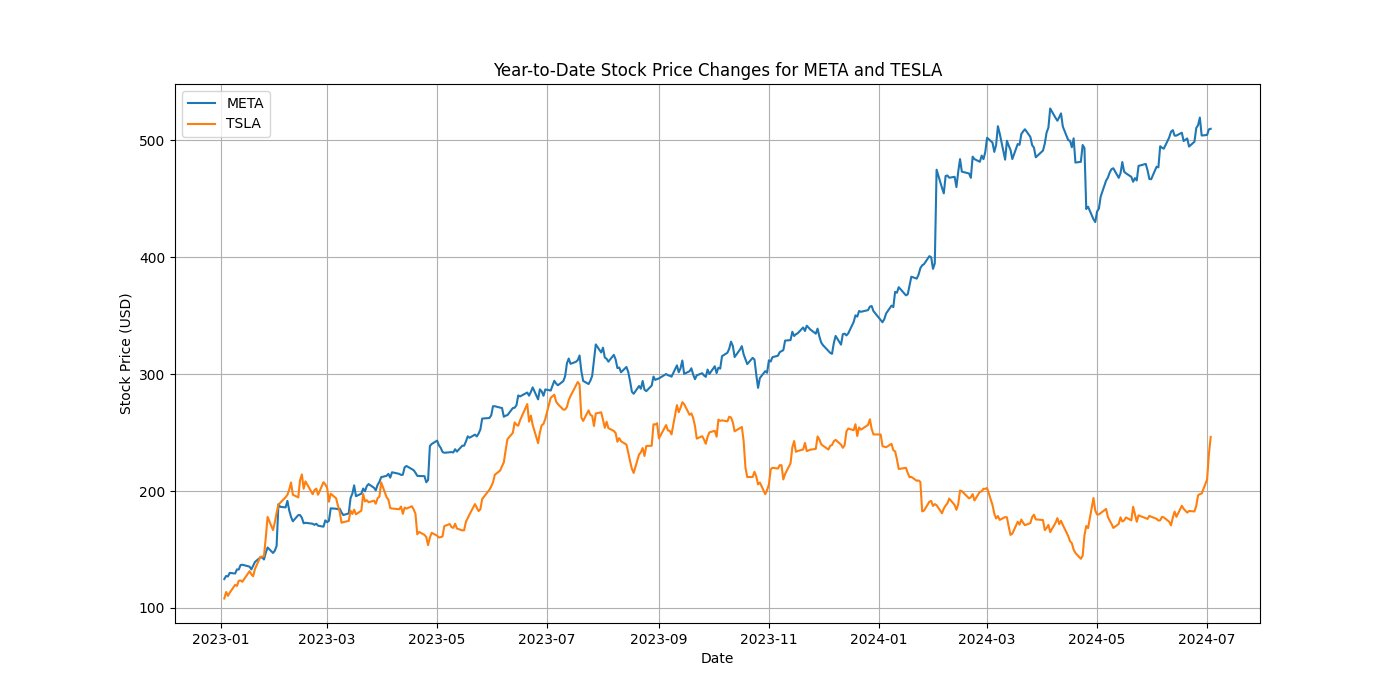

In [ ]:
try:
    image = Image(filename="coding/stock_price_ytd.png")
    display(image)
except FileNotFoundError:
    print("Image not found. Please check the file name and modify if necessary.")

Let's display the raw data collected and saved from previous chat as well.

In [ ]:
# Path to your CSV file
file_path = "coding/stock_price_ytd.csv"
try:
    with open(file_path, mode="r", encoding="utf-8") as file:
        # Read each line in the file
        for line in file:
            # Split the line into a list using the comma as a separator
            row = line.strip().split(",")
            # Print the list representing the current row
            print(row)
except FileNotFoundError:
    print("File not found. Please check the file name and modify if necessary.")

['Price', 'Adj Close', 'Adj Close', 'Close', 'Close', 'High', 'High', 'Low', 'Low', 'Open', 'Open', 'Volume', 'Volume']
['Ticker', 'META', 'TSLA', 'META', 'TSLA', 'META', 'TSLA', 'META', 'TSLA', 'META', 'TSLA', 'META', 'TSLA']
['Date', '', '', '', '', '', '', '', '', '', '', '', '']
['2023-01-03', '124.48419189453125', '108.0999984741211', '124.73999786376953', '108.0999984741211', '126.37000274658203', '118.80000305175781', '122.27999877929688', '104.63999938964844', '122.81999969482422', '118.47000122070312', '35528500', '231402800']
['2023-01-04', '127.10880279541016', '113.63999938964844', '127.37000274658203', '113.63999938964844', '129.0500030517578', '114.58999633789062', '125.8499984741211', '107.5199966430664', '127.37999725341797', '109.11000061035156', '32397100', '180389000']
['2023-01-05', '126.67967987060547', '110.33999633789062', '126.94000244140625', '110.33999633789062', '128.52000427246094', '111.75', '124.54000091552734', '107.16000366210938', '126.12999725341797', 

## Example Task: Use User Defined Message Function to let Agents Analyze data Collected

Let's create a user defined message to let the agents analyze the raw data and write a blogpost. The function is supposed to take `sender`, `recipient` and `context` as inputs and outputs a string of message.

**kwargs from `initiate_chat` will be used as `context`. Take the following code as an example, the `context` includes a field `file_name` as provided in `initiate_chat`. In the user defined message function `my_message_generator`, we are reading data from the file specified by this filename.


In [ ]:
def my_message_generator(sender, recipient, context):
    # your CSV file
    file_name = context.get("file_name")
    try:
        with open(file_name, mode="r", encoding="utf-8") as file:
            file_content = file.read()
    except FileNotFoundError:
        file_content = "No data found."
    return "Analyze the data and write a brief but engaging blog post. \n Data: \n" + file_content


# followup of the previous question
chat_res = user_proxy.initiate_chat(
    recipient=assistant,
    message=my_message_generator,
    file_name="coding/stock_price_ytd.csv",
    summary_method="reflection_with_llm",
    summary_args={"summary_prompt": "Return the blog post in Markdown format."},
)

user_proxy (to assistant):

Analyze the data and write a brief but engaging blog post. 
 Data: 
Date,META,TESLA
2024-01-02,346.2900085449219,248.4199981689453
2024-01-03,344.4700012207031,238.4499969482422
2024-01-04,347.1199951171875,237.92999267578125
2024-01-05,351.95001220703125,237.49000549316406
2024-01-08,358.6600036621094,240.4499969482422
2024-01-09,357.42999267578125,234.9600067138672
2024-01-10,370.4700012207031,233.94000244140625
2024-01-11,369.6700134277344,227.22000122070312
2024-01-12,374.489990234375,218.88999938964844
2024-01-16,367.4599914550781,219.91000366210938
2024-01-17,368.3699951171875,215.5500030517578
2024-01-18,376.1300048828125,211.8800048828125
2024-01-19,383.45001220703125,212.19000244140625
2024-01-22,381.7799987792969,208.8000030517578
2024-01-23,385.20001220703125,209.13999938964844
2024-01-24,390.70001220703125,207.8300018310547
2024-01-25,393.17999267578125,182.6300048828125
2024-01-26,394.1400146484375,183.25
2024-01-29,401.0199890136719,190.9299926

Let's check the summary of the chat

In [ ]:
print(chat_res.summary)

---

# A Comparative Analysis of META and TESLA Stocks in Early 2024

In the first quarter of 2024, the stock market saw some interesting movements in the tech sector. Two companies that stood out during this period were META and TESLA. 

META, the social media giant, had an average stock price of 403.53 during this period. The highest it reached was 519.83, while the lowest was 344.47. The standard deviation, a measure of how spread out the prices were, was 100.72.

On the other hand, TESLA, the electric vehicle and clean energy company, had an average stock price of 219.54. The stock reached a high of 248.42 and a low of 171.76. The standard deviation for TESLA was 41.68.

These figures show that both META and TESLA had their ups and downs during this period. However, the higher standard deviation for META indicates that its stock price fluctuated more compared to TESLA.

As we move further into 2024, it will be interesting to see how these trends evolve. Will META and TESLA continue

This is the blog post that the agents generated.

# A Comparative Analysis of META and TESLA Stocks in Early 2024

In the first quarter of 2024, the stock market saw some interesting movements in the tech sector. Two companies that stood out during this period were META and TESLA.

META, the social media giant, had an average stock price of 403.53 during this period. The highest it reached was 519.83, while the lowest was 344.47. The standard deviation, a measure of how spread out the prices were, was 100.72.

On the other hand, TESLA, the electric vehicle and clean energy company, had an average stock price of 219.54. The stock reached a high of 248.42 and a low of 171.76. The standard deviation for TESLA was 41.68.

These figures show that both META and TESLA had their ups and downs during this period. However, the higher standard deviation for META indicates that its stock price fluctuated more compared to TESLA.

As we move further into 2024, it will be interesting to see how these trends evolve. Will META and TESLA continue on their current trajectories, or will we see a shift in the market dynamics? Only time will tell.

Let's check how much the above chat cost

In [ ]:
print(chat_res.cost)

({'total_cost': 0.84249, 'gpt-4-0613': {'cost': 0.84249, 'prompt_tokens': 22513, 'completion_tokens': 2785, 'total_tokens': 25298}}, {'total_cost': 0.84249, 'gpt-4-0613': {'cost': 0.84249, 'prompt_tokens': 22513, 'completion_tokens': 2785, 'total_tokens': 25298}})
